# Import

In [1]:
#%matplotlib notebook
import numpy as np
from scipy.stats import norm
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import statistics
from scipy import signal
from scipy.optimize import curve_fit
import scipy.fftpack
import matplotlib.colors as colors

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Reading files

In [3]:
# Rl = 60; N=128
# folder_in = "small_ts/"
# nb_of_runs = 1

Rl = 90; N=256
folder_in = "time_series/"
nb_of_runs = 2
limit_iterations = True
iterations_per_run = 100000

common_folder = "/home/gorbunov8a/data/correlations/"
file_type = "time_series"
component = "Ux"
series_type = "lin"

# read real part time series
for run_index in list(range(nb_of_runs)) :
    part = 'Re'
    folder = common_folder + "rl" + str(Rl) + "_N" + str(N) + "/" + folder_in + "run" + "%01d" % (run_index+1) + "/"
    file = folder + file_type + "_" + part + "_" + component + "_" + series_type + ".table"
    file_list = []
    print(file)
    for line in open(file) :
        temp_array_line = []
        if line[0] == '#' :          #skip commented lines
            continue
        else :
            temp_array_line=list(map(float, line.split( )))
            file_list.append(temp_array_line)
    if limit_iterations :
        file_array = np.array(file_list[1:iterations_per_run + 1])
    else :
        file_array = np.array(file_list[1:-1])
    if (run_index == 0) :
        k = np.array(file_list[0])
        t = file_array[:,0]
        real_part = file_array[:,1:]
    else : 
        t = np.append(t, t[-1] + file_array[1:,0], axis=0)
        real_part = np.append(real_part, file_array[1:,1:], axis=0)

# read imaginary part time series
for run_index in list(range(nb_of_runs)) :
    part = 'Im'
    folder = common_folder + "rl" + str(Rl) + "_N" + str(N) + "/" + folder_in + "run" + "%01d" % (run_index+1) + "/"
    file = folder + file_type + "_" + part + "_" + component + "_" + series_type + ".table"
    file_list = []
    for line in open(file) :
        temp_array_line = []
        if line[0] == '#' :          #skip commented lines
            continue
        else :
            temp_array_line=list(map(float, line.split( )))
            file_list.append(temp_array_line)
    if limit_iterations :
        file_array = np.array(file_list[1:iterations_per_run +1])
    else :
        file_array = np.array(file_list[1:-1])
    if (run_index == 0) :
        imag_part = file_array[:,1:]
    else : 
        imag_part = np.append(imag_part, file_array[1:,1:], axis=0)        
        
del file_array, file_list, temp_array_line

complex_signal = real_part + imag_part*1j

/home/gorbunov8a/data/correlations/rl90_N256/time_series/run1/time_series_Re_Ux_lin.table
/home/gorbunov8a/data/correlations/rl90_N256/time_series/run2/time_series_Re_Ux_lin.table


# Define parameters

In [4]:
# PARAMETERS
if (Rl == 90) :
    lmbda = 0.268 
    eta = 0.0134  
    L=2.65
    dissipation_rate=0.31e-04
    urms=np.sqrt(3*0.2282712E-02/2)
elif (Rl == 60) :
    lmbda = 0.387 
    eta = 0.025  
    L=2.65 
    dissipation_rate=2.24565e-06
t0=dissipation_rate**(-1/3)*L**(2/3)

In [5]:
t0

60.95977443501051

# Samples

In [6]:
sample_duration = 2*t0
#sample_duration = t[-1]
wavenumbers_length = complex_signal.shape[1]
time_series_length = complex_signal.shape[0]
deltaT=float((t[-1]-t[0])/time_series_length)
iterations_per_sample = int(sample_duration//deltaT) 
nb_of_samples = round(time_series_length/iterations_per_sample)
samples = np.ndarray(shape=(nb_of_samples, iterations_per_sample, wavenumbers_length), dtype=complex)
for i in range(nb_of_samples) :
    a = i*iterations_per_sample
    b = (i+1)*iterations_per_sample 
    samples[i,:,:] = complex_signal[a:b, :]

In [7]:
print(nb_of_samples)

8


In [8]:
print('Simulation time = ', t[-1]/t0, 't_0')

Simulation time =  16.404096131721975 t_0


# Plotting params

In [9]:
kmin = 4
kmax = 20
nb_of_curves = 5
step = round((kmax - kmin)/nb_of_curves)
indices_of_k_to_plot=list(range(kmin,kmax,step))
indices_of_k_to_plot.append(50)
if Rl == 90 :
    indices_of_k_to_plot.append(100)
print(indices_of_k_to_plot)

[4, 7, 10, 13, 16, 19, 50, 100]


# Plot time series

In [10]:
# plots one sample : define paramaters of plotting
sample_index = 0
unwrap_phase = True
normalisation = True

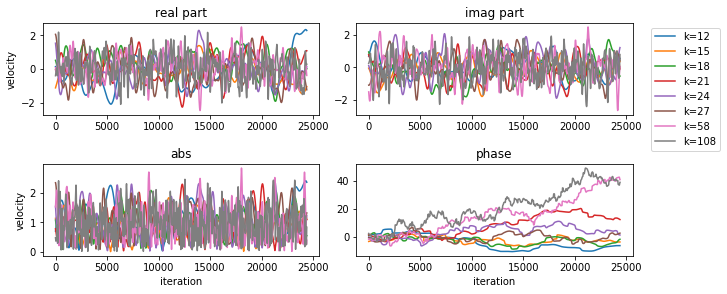

In [11]:
norm_coef = np.ndarray(shape=(wavenumbers_length), dtype=float)
fig, ((ax_re, ax_im), (ax_abs, ax_arg)) = plt.subplots(nrows=2, ncols=2,figsize=(10,4))
ax_re.set(title='real part', ylabel='velocity')
ax_im.set(title='imag part')
ax_abs.set(title='abs', xlabel='iteration', ylabel='velocity')
ax_arg.set(title='phase', xlabel='iteration')
for ik in indices_of_k_to_plot :
    if normalisation :
        norm_coef[ik] = 1/np.mean(np.absolute(complex_signal[:,ik]))
    else : 
        norm_coef[ik] = 1
    ax_re.plot(np.real(samples[sample_index,:,ik])*norm_coef[ik])
    ax_im.plot(np.imag(samples[sample_index,:,ik]*norm_coef[ik]), label='k=%2.f' % k[ik])
    ax_abs.plot(np.absolute(samples[sample_index,:,ik])*norm_coef[ik])
    if unwrap_phase : 
        ax_arg.plot(np.unwrap(np.angle(samples[sample_index,:,ik])))
    else :
        ax_arg.plot(np.angle(samples[sample_index,:,ik]))
ax_im.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
fig.tight_layout(pad=0.4, w_pad=0.5, h_pad=0.4)
#fig.show()

# Export image to pdf
#pp = PdfPages('Images/time_series.pdf')
#pp.savefig()
#pp.close()

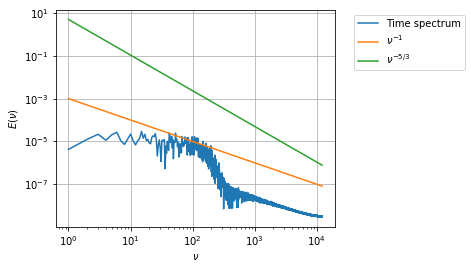

In [12]:
spectrum = np.fft.fft(samples[sample_index,:,115], axis=0)
Nx = spectrum.shape[0]
x = np.arange(0,Nx)

fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(5,4))
ax.plot(x[1:Nx//2],np.abs(spectrum[1:Nx//2]), label='Time spectrum')
ax.plot(x[1:Nx//2],10e-4*(x[1:Nx//2])**(-1.0), label=r'$\nu^{-1}$')
ax.plot(x[1:Nx//2],5e-0*(x[1:Nx//2])**(-5.0/3.0), label=r'$\nu^{-5/3}$')
ax.set(xlabel=r'$\nu$', ylabel=r'$E(\nu)$', xscale='log', yscale='log'); ax.grid()
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [13]:
samples[sample_index,:,50]

array([ 2.02700897e-08-4.41052494e-07j,  1.79890757e-08-4.43775367e-07j,
        1.57578744e-08-4.46482037e-07j, ...,
       -1.10206753e-07+5.51726452e-09j, -1.11663845e-07+6.99791143e-09j,
       -1.13045584e-07+8.44485902e-09j])

# PDF

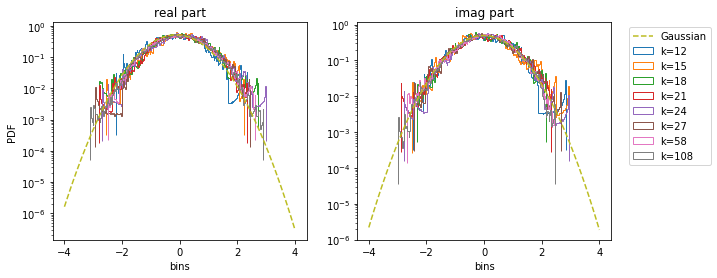

In [14]:
#plot histogram
nb_of_bins=200

fig, (ax_re, ax_im) = plt.subplots(nrows=1, ncols=2,figsize=(10,4))
for ik in indices_of_k_to_plot :
    ax_re.hist(x=np.real(complex_signal[:,ik])*norm_coef[ik], bins=nb_of_bins, histtype='step', density=True, log=True, align='mid')
    ax_im.hist(x=np.imag(complex_signal[:,ik])*norm_coef[ik], bins=nb_of_bins, histtype='step', density=True, log=True, align='mid', label='k=%2.f' % k[ik])
#plot gaussian fit   
ik = indices_of_k_to_plot[0]
xmin, xmax = plt.xlim()
x = np.linspace(-4, 4, 100)

mean,std=norm.fit(np.real(complex_signal[:,ik])*norm_coef[ik])
y = norm.pdf(x, mean, std)
ax_re.plot(x, y, '--')

mean,std=norm.fit(np.imag(complex_signal[:,ik])*norm_coef[ik])
y = norm.pdf(x, mean, std)
ax_im.plot(x, y, '--', label = 'Gaussian')

ax_re.set(title='real part', ylabel='PDF', xlabel='bins')
ax_im.set(title='imag part', xlabel='bins')
ax_im.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Autocorrelation of the complex signal

In [15]:
# parameters to define
normalization_flag=True
unwrap_phase = False

In [16]:
# allocation and initialization
length_lags = iterations_per_sample
# values in the vector of time lags are non-dimensional
#lags = np.array(range(-length_lags//2,length_lags//2))*deltaT/t0 
lags = np.array(range(-length_lags,length_lags-1))*deltaT/t0 
length_lags = len(lags)

autocorrelation_of_sample = np.ndarray(shape=(nb_of_samples, length_lags, wavenumbers_length), dtype=complex)
phase_of_sample = np.ndarray(shape=(nb_of_samples, length_lags, wavenumbers_length), dtype=float)
phase_of_sample_sqr = np.ndarray(shape=(nb_of_samples, length_lags, wavenumbers_length), dtype=float)

In [17]:
# COMPUTE autocorrelation of each sample
for i in range(nb_of_samples) :
    for ik in range(1, wavenumbers_length) :
        #data_to_correlate = np.absolute(samples[i,:,ik])
        data_to_correlate = samples[i,:,ik] #use the complex signal
        autocorrelation_of_sample[i,:,ik] = signal.correlate(data_to_correlate, data_to_correlate, mode='full', method='fft')
        if unwrap_phase :
            phase_of_sample[i,:,ik] = np.unwrap(np.angle(autocorrelation_of_sample[i,:, ik]))
        else : 
            phase_of_sample[i,:,ik] = np.angle(autocorrelation_of_sample[i,:, ik])
        phase_of_sample_sqr[i,:,ik] = phase_of_sample[i,:,ik]**2
# averaging over all samples
autocorrelation_complex = np.mean(autocorrelation_of_sample, axis=0)
mean_phase = np.mean(phase_of_sample, axis=0)
mean_phase_sqr = np.mean(phase_of_sample_sqr, axis=0)
phase_variance = np.abs(mean_phase_sqr - mean_phase**2)
#autocorrelation_complex = autocorrelation_of_sample[0,:,:]

In [18]:
# NORMALIZATION of  the autocorrelation by the value of correlation at the time lag=0
normalization_of_correlation = np.ndarray(shape=(wavenumbers_length), dtype=float)
normalization_of_correlation.fill(1.0)
if normalization_flag :
    normalization_of_correlation[1::] = np.absolute(autocorrelation_complex[lags.shape[0]//2, 1::])**-1         

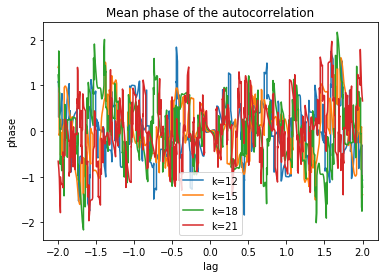

In [19]:
for ik in indices_of_k_to_plot[0:-4] :
    plt.plot(lags,mean_phase[:,ik], label='k=%2.f' % k[ik])
plt.legend()
plt.xlabel('lag'); plt.ylabel('phase')
plt.title('Mean phase of the autocorrelation')
plt.show()

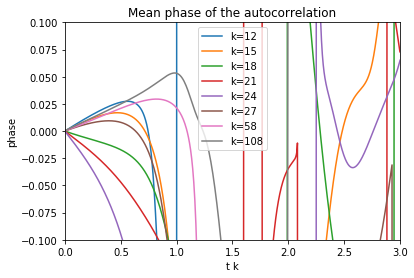

In [20]:
lag1 = -0.0
lag2 = 1.0
a = np.searchsorted(lags, lag1)
b = np.searchsorted(lags, lag2)
for ik in indices_of_k_to_plot :
    plt.plot(lags[a:b]*k[ik]**(1.0),mean_phase[a:b,ik], label='k=%2.f' % k[ik])
plt.xlabel('t k'); plt.ylabel('phase')
plt.ylim([-0.1, 0.1])
plt.xlim([0.0, 3.0])
plt.title('Mean phase of the autocorrelation')
plt.legend()
plt.show()

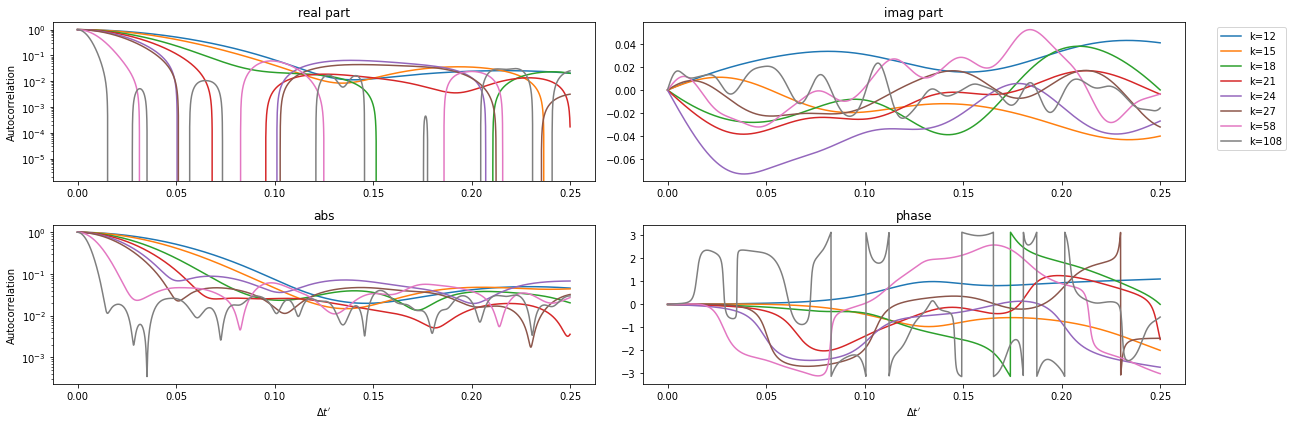

In [21]:
#Plotting area
lag1 = 0
lag2 = 0.25

# Parameters
unwrap_phase = False

# find the corresponding indexes in the lag vector
a = np.searchsorted(lags, lag1)
b = np.searchsorted(lags, lag2)

fig, ((ax_re, ax_im), (ax_abs, ax_arg)) = plt.subplots(nrows=2, ncols=2,figsize=(18,6))
#for ik in indices_of_k_to_plot[0:-2] :
for ik in indices_of_k_to_plot :
    ax_re.semilogy(lags[a:b], np.real(autocorrelation_complex[a:b, ik])*normalization_of_correlation[ik],'-')
    ax_im.plot(lags[a:b], np.imag(autocorrelation_complex[a:b, ik])*normalization_of_correlation[ik],'-', label='k=%2.f' % k[ik])
    ax_abs.semilogy(lags[a:b], np.absolute(autocorrelation_complex[a:b, ik])*normalization_of_correlation[ik],'-')
    if unwrap_phase :
        ax_arg.plot(lags[a:b], np.unwrap(np.angle(autocorrelation_complex[a:b, ik])),'-')
    else :
        ax_arg.plot(lags[a:b], np.angle(autocorrelation_complex[a:b, ik]),'-')
ax_re.set(title='real part', ylabel='Autocorrelation')
ax_im.set(title='imag part')
ax_abs.set(title='abs', ylabel='Autocorrelation', xlabel=r'$\Delta t ^\prime$')
ax_arg.set(title='phase', xlabel=r'$\Delta t ^\prime$')
ax_im.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
fig.tight_layout()

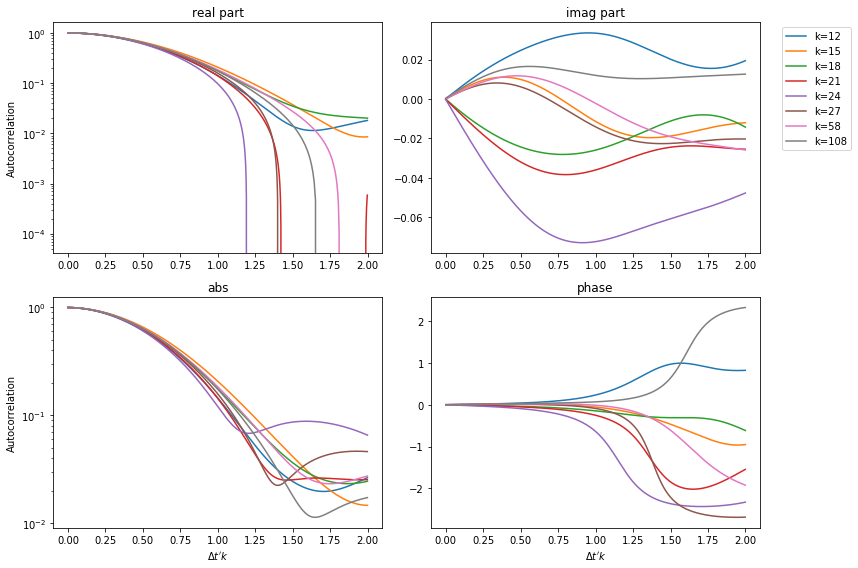

In [22]:
#Plotting area
tk1 = 0
tk2 = 2.0

# Parameters
unwrap_phase = True

# find the corresponding indexes in the lag vector

fig, ((ax_re, ax_im), (ax_abs, ax_arg)) = plt.subplots(nrows=2, ncols=2,figsize=(12,8))
#for ik in indices_of_k_to_plot[0:-2] :
for ik in indices_of_k_to_plot :
    a = np.searchsorted(lags*k[ik], tk1)
    b = np.searchsorted(lags*k[ik], tk2)
    ax_re.semilogy(lags[a:b]*k[ik], np.real(autocorrelation_complex[a:b, ik])*normalization_of_correlation[ik],'-')
    ax_im.plot(lags[a:b]*k[ik], np.imag(autocorrelation_complex[a:b, ik])*normalization_of_correlation[ik],'-', label='k=%2.f' % k[ik])
    ax_abs.semilogy(lags[a:b]*k[ik], np.absolute(autocorrelation_complex[a:b, ik])*normalization_of_correlation[ik],'-')
    if unwrap_phase :
        ax_arg.plot(lags[a:b]*k[ik], np.unwrap(np.angle(autocorrelation_complex[a:b, ik])),'-')
    else :
        ax_arg.plot(lags[a:b]*k[ik], np.angle(autocorrelation_complex[a:b, ik]),'-')
ax_re.set(title='real part', ylabel='Autocorrelation')
ax_im.set(title='imag part')
ax_abs.set(title='abs', ylabel='Autocorrelation', xlabel=r'$\Delta t ^\prime k$')
ax_arg.set(title='phase', xlabel=r'$\Delta t ^\prime k$')
ax_im.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
fig.tight_layout()

In [23]:
#slope of the phase


## Fitting correlation of the complex signal

In [24]:
# Define the functions to fit

def gaussian(x, a, b, c):   
    return a * np.exp(-b * x**2) + c
gaussian_nb_of_params = 3 

# exponential
def exponent_function(x, a, b, c):   
    return a * np.exp(-b * x) + c
exponent_nb_of_params = 3

### Short time lags - Gaussian

In [25]:
#short lags - calculate fit
tk1_gauss = 0.0
tk2_gauss = 3.0

optim_coef1 = np.ndarray(shape=(wavenumbers_length, gaussian_nb_of_params), dtype=float)
cov_matrix1 = np.ndarray(shape=(wavenumbers_length, gaussian_nb_of_params, gaussian_nb_of_params), dtype=float)
for ik in range(wavenumbers_length) :
    a = np.searchsorted(lags*k[ik]*L, tk1_gauss)
    b = np.searchsorted(lags*k[ik]*L, tk2_gauss)
    xdata = lags[a:b]*k[ik]*L   # t'k' variable
    #print('Fitting using', np.count_nonzero(xdata), 'points')
    ydata = np.real(autocorrelation_complex[a:b, ik])*normalization_of_correlation[ik]
    try :
        optim_coef1[ik, :], cov_matrix1[ik, :, :] = curve_fit(gaussian, xdata, ydata)
    except :
        print('Failed optimization for ik = ', ik)
        optim_coef1[ik,:].fill(np.nan)
        continue        

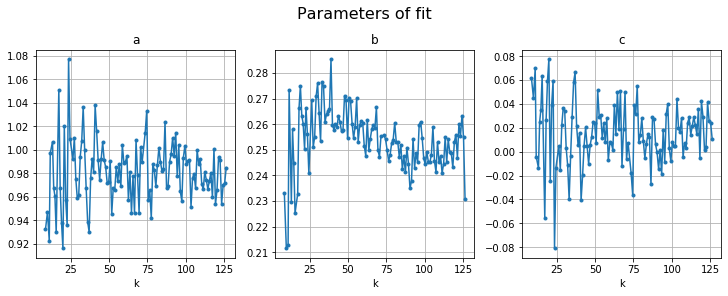

In [26]:
# plot fitting coeffiecients
fig, (ax_a, ax_b, ax_c) = plt.subplots(nrows=1, ncols=3,figsize=(10,4), constrained_layout=True)
ik1 = 1; ik2 = wavenumbers_length-1
ax_a.plot(k[ik1:ik2], optim_coef1[ik1:ik2, 0], '.-')
ax_b.plot(k[ik1:ik2], optim_coef1[ik1:ik2, 1], '.-')
ax_c.plot(k[ik1:ik2], optim_coef1[ik1:ik2, 2], '.-')
ax_a.set(title='a', xlabel='k'); ax_a.grid()
ax_b.set(title='b', xlabel='k'); ax_b.grid()
ax_c.set(title='c', xlabel='k'); ax_c.grid()
fig.suptitle('Parameters of fit', fontsize=16)
plt.show()

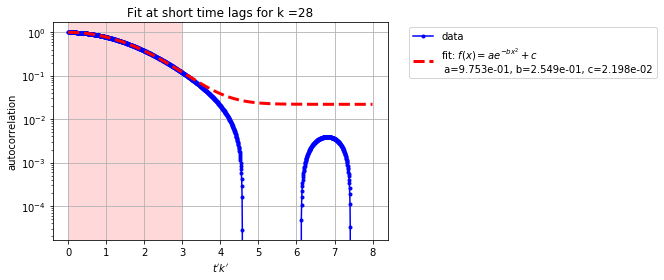

In [27]:
# Example of the gaussian fit for one wavenumber
ik = 20
a = np.searchsorted(lags*k[ik]*L, tk1_gauss)
b = np.searchsorted(lags*k[ik]*L, tk2_gauss+5)
coef_vector = optim_coef1[ik,:]
plt.plot(lags[a:b]*k[ik]*L, np.real(autocorrelation_complex[a:b, ik])*normalization_of_correlation[ik], 'b.-', label='data')
plt.plot(lags[a:b]*k[ik]*L, gaussian(lags[a:b]*k[ik]*L, *coef_vector), 'r--', linewidth=3, label=r'fit: $f(x) = a e^{-b x^2} + c$' + "\n" + ' a=%5.3e, b=%5.3e, c=%5.3e' % tuple(coef_vector))
plt.xlabel(r'$t^\prime k^\prime$'); plt.ylabel('autocorrelation'); plt.grid()
plt.axvspan(tk1_gauss, tk2_gauss, facecolor='red', alpha=0.15)
plt.title('Fit at short time lags for k =%2.f' % k[ik])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.yscale("log")
plt.show()

### Long time lags

In [28]:
# fitting range : 
tk1_long = 4.0
tk2_long = 6.5

optim_coef2 = np.ndarray(shape=(wavenumbers_length, 3), dtype=float)
cov_matrix2 = np.ndarray(shape=(wavenumbers_length, 3, 3), dtype=float)
for ik in range(wavenumbers_length) :
    a = np.searchsorted(lags*k[ik]*L, tk1_long)
    b = np.searchsorted(lags*k[ik]*L, tk2_long)
    xdata = lags[a:b]*k[ik]*L
    #print('[debug] Fitting using', np.count_nonzero(xdata), 'points')
    ydata = np.real(autocorrelation_complex[a:b, ik])*normalization_of_correlation[ik]
    try :
        optim_coef2[ik, :], cov_matrix2[ik,:,:] = curve_fit(exponent_function, xdata, ydata)
    except :
        print('Failed optimization for ik = ', ik)
        optim_coef2[ik,:].fill(np.nan)
        continue
    max_param_std = 100
    if (np.count_nonzero(np.sqrt(np.diag(cov_matrix2[ik,:,:])>max_param_std)) > 0) :
        #print('point out ik = ', ik)
        cov_matrix2[ik,:,:].fill(np.nan)
        optim_coef2[ik,:].fill(np.nan)

/home/gorbunov8a/.local/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


Failed optimization for ik =  51
Failed optimization for ik =  53


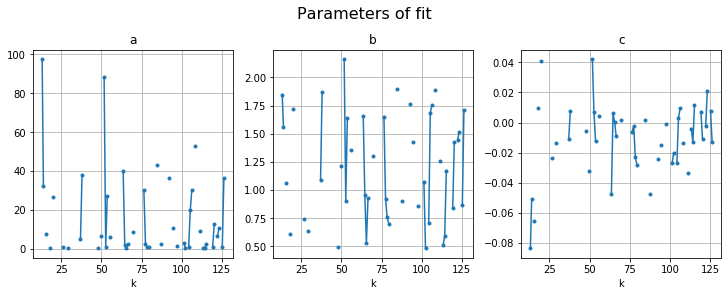

In [29]:
# plot fitting coeffiecients
fig, (ax_a, ax_b, ax_c) = plt.subplots(nrows=1, ncols=3,figsize=(10,4), constrained_layout=True)
ik1 = 1; ik2 = wavenumbers_length-1
ax_a.plot(k[ik1:ik2], optim_coef2[ik1:ik2, 0],'.-')
ax_b.plot(k[ik1:ik2], optim_coef2[ik1:ik2, 1],'.-')
ax_c.plot(k[ik1:ik2], optim_coef2[ik1:ik2, 2],'.-')
ax_a.set(title='a', xlabel='k'); ax_a.grid()
ax_b.set(title='b', xlabel='k'); ax_b.grid()
ax_c.set(title='c', xlabel='k'); ax_c.grid()
fig.suptitle('Parameters of fit', fontsize=16)
plt.show()

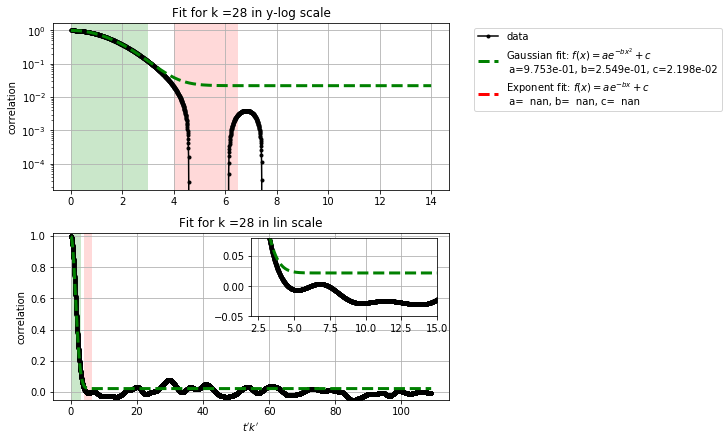

In [30]:
# Example of the exponential fit for one wavenumber
ik = 20
a = np.searchsorted(lags*k[ik]*L, 0)
b = np.searchsorted(lags*k[ik]*L, tk1_long+10)
coef_vector = optim_coef2[ik,:]

fig, (ax_log, ax_lin) = plt.subplots(nrows=2, ncols=1, figsize=(10,6), constrained_layout=True)
ax_log.plot(lags[a:b]*k[ik]*L, np.real(autocorrelation_complex[a:b, ik])*normalization_of_correlation[ik], 'k.-', label='data')
ax_log.plot(lags[a:b]*k[ik]*L, gaussian(lags[a:b]*k[ik]*L, *optim_coef1[ik,:]), 'g--', linewidth=3, label=r'Gaussian fit: $f(x) = a e^{-b x^2} + c$' + "\n" + ' a=%5.3e, b=%5.3e, c=%5.3e' % tuple(optim_coef1[ik,:]))
ax_log.plot(lags[a:b]*k[ik]*L, exponent_function(lags[a:b]*k[ik]*L, *optim_coef2[ik,:]), 'r--', linewidth=3, label=r'Exponent fit: $f(x) = a e^{-b x} + c$' + "\n" + ' a=%5.3e, b=%5.3e, c=%5.3e' % tuple(optim_coef2[ik,:]))
ax_log.axvspan(tk1_long, tk2_long, facecolor='red', alpha=0.15)
ax_log.axvspan(tk1_gauss, tk2_gauss, facecolor='#2ca02c', alpha=0.25)
ax_log.set(yscale="log", ylabel='correlation', title='Fit for k =%2.f' % (k[ik]) +' in y-log scale'); ax_log.grid()
ax_log.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

a = np.searchsorted(lags*k[ik]*L, 0)
b = np.searchsorted(lags*k[ik]*L, tk1_long+105)
ax_lin.plot(lags[a:b]*k[ik]*L, np.real(autocorrelation_complex[a:b, ik])*normalization_of_correlation[ik], 'k.-', label='data')
ax_lin.plot(lags[a:b]*k[ik]*L, gaussian(lags[a:b]*k[ik]*L, *optim_coef1[ik,:]), 'g--', linewidth=3, label=r'Gaussian fit: $f(x) = a e^{-b x^2} + c$' + "\n" + ' a=%5.3e, b=%5.3e, c=%5.3e' % tuple(optim_coef1[ik,:]))
ax_lin.plot(lags[a:b]*k[ik]*L, exponent_function(lags[a:b]*k[ik]*L, *optim_coef2[ik,:]), 'r--', linewidth=3, label=r'Exponent fit: $f(x) = a e^{-b x} + c$' + "\n" + ' a=%5.3e, b=%5.3e, c=%5.3e' % tuple(optim_coef2[ik,:]))
ax_lin.axvspan(tk1_long, tk2_long, facecolor='red', alpha=0.15)
ax_lin.axvspan(tk1_gauss, tk2_gauss, facecolor='#2ca02c', alpha=0.25)
ax_lin.set(ylim=(-0.05,1.02), xlabel=r'$t^\prime k^\prime$', ylabel='correlation',title='Fit for k =%2.f' % (k[ik]) +' in lin scale'); ax_lin.grid()

zoom = ax_lin.inset_axes([0.5, 0.5, 0.47, 0.47])
zoom.plot(lags[a:b]*k[ik]*L, np.real(autocorrelation_complex[a:b, ik])*normalization_of_correlation[ik], 'k.-', label='data')
zoom.plot(lags[a:b]*k[ik]*L, gaussian(lags[a:b]*k[ik]*L, *optim_coef1[ik,:]), 'g--', linewidth=3, label=r'Gaussian fit: $f(x) = a e^{-b x^2} + c$' + "\n" + ' a=%5.3e, b=%5.3e, c=%5.3e' % tuple(optim_coef1[ik,:]))
zoom.plot(lags[a:b]*k[ik]*L, exponent_function(lags[a:b]*k[ik]*L, *optim_coef2[ik,:]), 'r--', linewidth=3, label=r'Exponent fit: $f(x) = a e^{-b x} + c$' + "\n" + ' a=%5.3e, b=%5.3e, c=%5.3e' % tuple(optim_coef2[ik,:]))
#zoom.axvspan(tk1_long, tk2_long, facecolor='red', alpha=0.15)
#zoom.axvspan(tk1_gauss, tk2_gauss, facecolor='#2ca02c', alpha=0.25)
zoom.set(ylim=(-0.05,0.08), xlim=(2,15), yscale="linear"); zoom.grid()
plt.show()

# FFT of the complex autocorrelation (time spectrum)

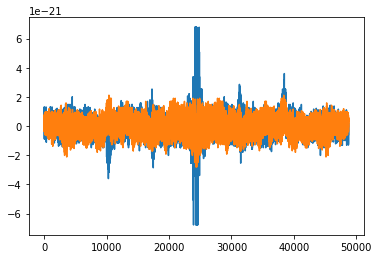

In [31]:
# check Hermitian symmetry of the complex autocorrelation
ik = 10
plt.plot(np.real(np.conj(np.flip(autocorrelation_complex[:,ik])) - autocorrelation_complex[:,ik]))
plt.plot(np.imag(np.conj(np.flip(autocorrelation_complex[:,ik])) - autocorrelation_complex[:,ik]))

In [32]:
# compute spectrum of autocorrelation
N = length_lags
x = lags
delta = x[1]-x[0]
a=np.round(x[0]/delta)
shift_vector = np.exp(-1.0j * 2*np.pi*a*(np.arange(N))/(N))
nu = np.fft.fftfreq(N, delta)
nu = np.fft.fftshift(nu)
time_spectrum = np.ndarray(shape=(N, wavenumbers_length), dtype=complex)
# time_spectrum_of_sample = np.ndarray(shape=(nb_of_samples, N, wavenumbers_length), dtype=complex)
# for index_sample in list(range(nb_of_samples)) :
#     for ik in list(range(wavenumbers_length)) :
#         yf = np.multiply(np.fft.fft(autocorrelation_of_sample[i,:, ik]), shift_vector)
#         time_spectrum_of_sample[index_sample, :, ik] = 1.0/N*np.fft.fftshift(yf)
# time_spectrum = np.mean(time_spectrum_of_sample, axis=0)

for ik in list(range(wavenumbers_length)) :
    time_spectrum[:, ik] = 1.0/N*np.fft.fftshift(np.multiply(np.fft.fft(autocorrelation_complex[:,ik], axis=0), shift_vector))

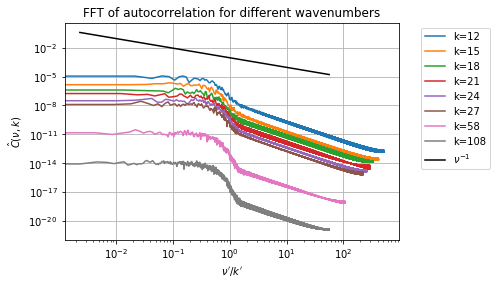

In [33]:
#y = fft(autocorrelation_complex)
for ik in indices_of_k_to_plot :
    normalization = np.absolute(time_spectrum[N//2,ik])
    horizontal_scale = 1.0/(k[ik])
    plt.plot(nu*horizontal_scale, np.absolute(time_spectrum[:,ik]), '-', label='k=%2.f' % k[ik])
#plt.xlim(-15, 15) 
plt.plot(nu[N//2+1::]*horizontal_scale, 10e-2*nu[N//2+1::]**(-1), 'k-', label=r'$\nu^{-1}$')
plt.xscale('log'); plt.yscale('log')
plt.xlabel(r'$\nu^\prime / k^\prime$'); plt.ylabel(r'$\hat{C} (\nu, k)$')
plt.title('FFT of autocorrelation for different wavenumbers')
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

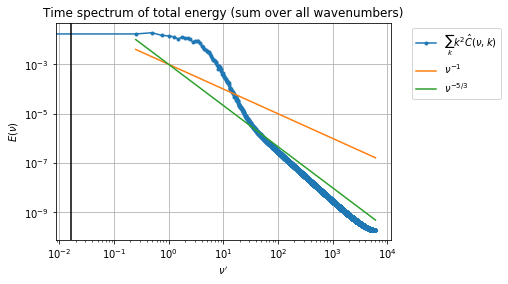

In [34]:
total_energy_spectrum = np.zeros(shape=N, dtype=float)
for ik in list(range(wavenumbers_length)) : 
    normalization = np.absolute(time_spectrum[N//2,ik])
    total_energy_spectrum = total_energy_spectrum + np.absolute(time_spectrum[:,ik]) * k[ik]*k[ik] 
plt.plot(nu, total_energy_spectrum, '.-', label=r'$\sum_k k^2 \hat{C} (\nu, k)$')
plt.plot(nu[N//2+1::], 10e-4*nu[N//2+1::]**(-1), '-', label=r'$\nu^{-1}$')
plt.plot(nu[N//2+1::], 1e-3*nu[N//2+1::]**(-5.0/3.0), '-', label=r'$\nu^{-5/3}$')
plt.xscale('log'); plt.yscale('log')
plt.xlabel(r'$\nu^\prime$'); plt.ylabel(r'$E (\nu)$')
plt.title('Time spectrum of total energy (sum over all wavenumbers)')
plt.grid()
plt.axvline(x=1/t0, color='k')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [35]:
nu.shape

(48767,)

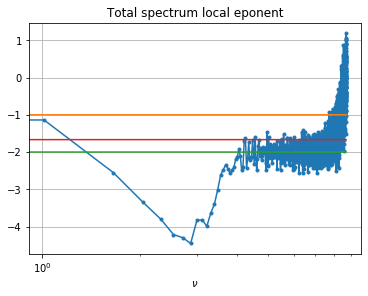

In [36]:
# check the slope of the time spectrum
resampling = 10
x = np.log(nu[N//2+1::resampling])
f = np.log(total_energy_spectrum[N//2+1::resampling])
slope = np.gradient(f, x)

fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(5,4))
ax.plot(x[:-1:], slope[:-1:], '.-')
ax.plot(x[:-1:], -1*np.ones_like(x[:-1:]), '-')
ax.plot(x[:-1:], -2*np.ones_like(x[:-1:]), '-')
ax.plot(x[:-1:], -5/3*np.ones_like(x[:-1:]), '-')
ax.set(xlabel=r'$\nu$', xscale='log', title='Total spectrum local eponent'); ax.grid()
plt.show()

## Spatio-temporal spectrum

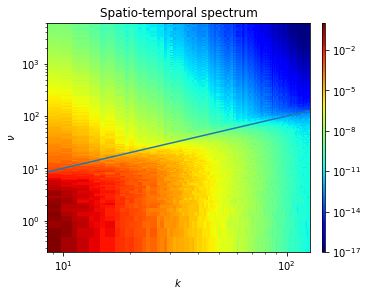

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=1, constrained_layout=True,figsize=(5,4))
normalization = 1.0/np.max(np.absolute(time_spectrum[:,:]))
im = ax.pcolormesh(k, nu[N//2+1::], np.absolute(time_spectrum[N//2+1::,:])*normalization, cmap='jet', norm=colors.LogNorm(vmin=1e-17, vmax=1.0))
ax.plot(k,k)
ax.set(xscale='log', yscale='log', title='Spatio-temporal spectrum', xlabel=r'$k$', ylabel=r'$\nu$')
fig.colorbar(im, ax=ax, aspect=100)
plt.show()

In [38]:
 np.absolute(time_spectrum)*normalization

array([[0.00000000e+00, 3.54305835e-09, 4.39757070e-09, ...,
        2.34829150e-18, 6.17170503e-18, 4.70109776e-18],
       [0.00000000e+00, 5.65904158e-09, 3.10056185e-09, ...,
        4.36951195e-18, 4.30748183e-18, 5.32420505e-18],
       [0.00000000e+00, 3.53797083e-09, 4.38978011e-09, ...,
        2.29888435e-18, 6.19454301e-18, 4.77283793e-18],
       ...,
       [0.00000000e+00, 5.66100146e-09, 3.10116217e-09, ...,
        4.44465311e-18, 4.39809617e-18, 5.33947147e-18],
       [0.00000000e+00, 3.54851549e-09, 4.39425044e-09, ...,
        2.25010856e-18, 6.14769020e-18, 4.80709512e-18],
       [0.00000000e+00, 5.65699145e-09, 3.10293224e-09, ...,
        4.43068638e-18, 4.31945919e-18, 5.37286293e-18]])

## Spatial spectrum

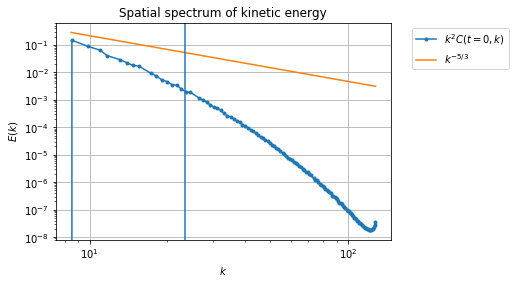

In [39]:
spatial_energy_spectrum1 = np.zeros(shape=wavenumbers_length, dtype=float)
spatial_energy_spectrum2 = np.zeros(shape=wavenumbers_length, dtype=float)
for ik in list(range(wavenumbers_length)) : 
    spatial_energy_spectrum1[ik] = np.real(autocorrelation_complex[N//2, ik]) * k[ik]*k[ik]
plt.plot(k, spatial_energy_spectrum1, '.-', label=r'$k^2 C (t=0, k)$')
plt.plot(k, 10e0*k**(-5.0/3.0), label=r'$k^{-5/3}$')
plt.xscale('log'); plt.yscale('log')
plt.axvline(x=2*np.pi/lmbda)
plt.xlabel(r'$k$'); plt.ylabel(r'$E (k)$')
plt.title('Spatial spectrum of kinetic energy')
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [40]:
# # check the slope of the spatial spectrum
# resampling = 2
# x = np.log(k[::resampling])
# f = np.log(spatial_energy_spectrum1[::resampling])
# slope = np.gradient(f, x)
# plt.plot(x[:-1:], slope[:-1:], '.-')
# plt.plot(x[:-1:], -1*np.ones_like(x[:-1:]), '-')
# plt.plot(x[:-1:], -5/3*np.ones_like(x[:-1:]), '-')
# plt.plot(x[:-1:], -11/3*np.ones_like(x[:-1:]), '-')
# plt.xscale('log')

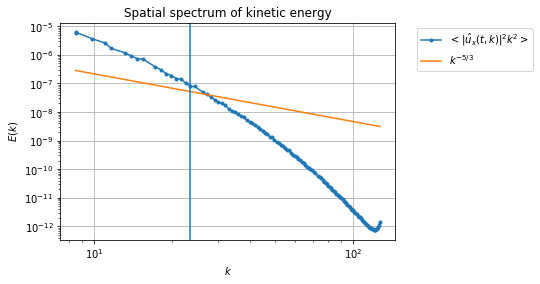

In [41]:
#kinetic_energy = np.zeros(shape=wavenumbers_length, dtype=float)
#kinetic_energy = np.mean(np.absolute(samples)**2.0,axis=(0,1))
kinetic_energy = np.multiply(np.mean(np.power(np.absolute(samples),2.0),axis=(0,1)),np.power(k,2))
plt.plot(k, kinetic_energy, '.-', label=r'$<|\hat{u}_x (t, k)|^2 k^2>$')
plt.plot(k, 10e-6*k**(-5.0/3.0), label=r'$k^{-5/3}$')
plt.xscale('log'); plt.yscale('log')
plt.axvline(x=2*np.pi/lmbda)
plt.xlabel(r'$k$'); plt.ylabel(r'$E (k)$')
plt.title('Spatial spectrum of kinetic energy')
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Autocorrelation of the amplitudes of signal

In [42]:
# parameters to define
normalization_flag=True

## Filtering

In [43]:
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=4):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, data)
    return y

In [44]:
samples.shape[1]

24384

In [45]:
# compute spectrum of autocorrelation
filtered_sample = np.ndarray(shape=(nb_of_samples, samples.shape[1], wavenumbers_length), dtype=complex)

for i in range(nb_of_samples) :
    for ik in list(range(wavenumbers_length)) :
        filtered_sample[i, :, ik] = butter_highpass_filter(samples[i,:,ik], 0.5*k[ik], 1.0/delta)

In [46]:
length_lags = iterations_per_sample
# values in the vector of time lags are non-dimensional
lags = np.array(range(-length_lags//2,length_lags//2))*deltaT/t0 
# COMPUTE autocorrelation of each sample
autocorrelation_of_sample = np.ndarray(shape=(nb_of_samples, length_lags, wavenumbers_length), dtype=float)
autocorrelation_ampl = np.ndarray(shape=(length_lags, wavenumbers_length), dtype=float)
for i in range(nb_of_samples) :
    for ik in range(1, wavenumbers_length) :
        data_to_correlate = (filtered_sample[i,:,ik]) #use the amplitudes of the signal
        autocorrelation_of_sample[i,:,ik] = signal.correlate(data_to_correlate - np.mean(data_to_correlate), data_to_correlate - np.mean(data_to_correlate), \
                                                             mode='same', method='fft')
# averaging over all samples
autocorrelation_ampl = np.mean(autocorrelation_of_sample, axis=0)

/home/gorbunov8a/.local/lib/python3.6/site-packages/ipykernel_launcher.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  # This is added back by InteractiveShellApp.init_path()


In [47]:
# NORMALIZATION of  the autocorrelation by the value of correlation at the time lag=0
normalization_of_correlation_ampl = np.ndarray(shape=(wavenumbers_length), dtype=float)
normalization_of_correlation_ampl.fill(1.0)
if normalization_flag :
    normalization_of_correlation_ampl[1::] = (autocorrelation_ampl[lags.shape[0]//2, 1::])**-1         

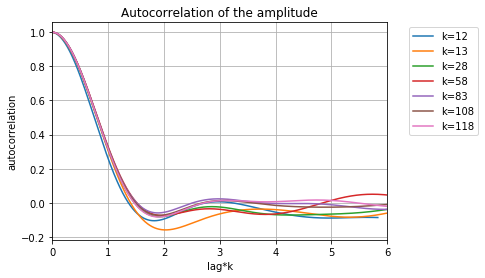

In [48]:
#Plotting area
lag1 = 0
lag2 = 0.5

# find the corresponding indexes in the lag vector
a = np.searchsorted(lags, lag1)
b = np.searchsorted(lags, lag2)

for ik in [4,5,20,50,75,100,110] :
    plt.plot(lags[a:b]*k[ik], autocorrelation_ampl[a:b, ik]*normalization_of_correlation_ampl[ik],'-', label="k=%2.f" % k[ik])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlim([0,6])
plt.xlabel('lag*k'); plt.ylabel('autocorrelation'); plt.grid()
plt.title('Autocorrelation of the amplitude')
#plt.yscale('log')
plt.show()

## Fitting correlation

### Short time lags - Gaussian

In [49]:
#short lags - calculate fit
tk1_gauss = 0.0
tk2_gauss = 2.0

optim_coef_long1 = np.ndarray(shape=(wavenumbers_length, 3), dtype=float)
for ik in range(wavenumbers_length) :
    a = np.searchsorted(lags*k[ik]*L, tk1_gauss)
    b = np.searchsorted(lags*k[ik]*L, tk2_gauss)
    xdata = lags[a:b]*k[ik]*L
    #print('Fitting using', np.count_nonzero(xdata), 'points')
    ydata = autocorrelation_ampl[a:b, ik]*normalization_of_correlation_ampl[ik]
    optim_coef_long1[ik, :], pcov = curve_fit(gaussian, xdata, ydata, [1.1, 10, 0.01])

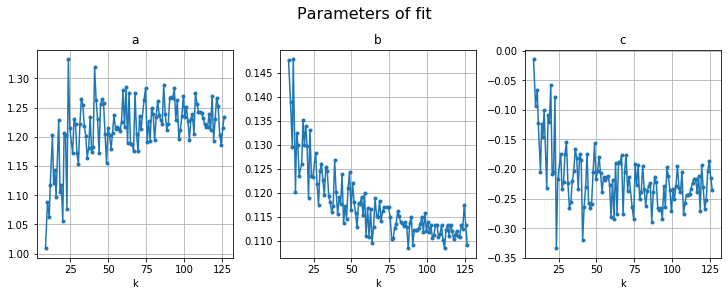

In [50]:
# plot fitting coeffiecients
fig, (ax_a, ax_b, ax_c) = plt.subplots(nrows=1, ncols=3,figsize=(10,4), constrained_layout=True)
ik1 = 1; ik2 = wavenumbers_length-1
ax_a.plot(k[ik1:ik2], optim_coef_long1[ik1:ik2, 0],'.-')
ax_b.plot(k[ik1:ik2], optim_coef_long1[ik1:ik2, 1],'.-')
ax_c.plot(k[ik1:ik2], optim_coef_long1[ik1:ik2, 2],'.-')
ax_a.set(title='a', xlabel='k'); ax_a.grid()
ax_b.set(title='b', xlabel='k'); ax_b.grid()
ax_c.set(title='c', xlabel='k'); ax_c.grid()
fig.suptitle('Parameters of fit', fontsize=16)
plt.show()

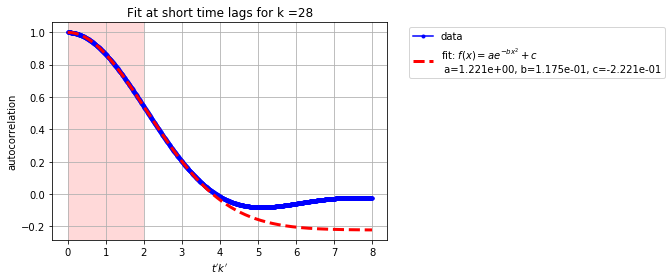

In [51]:
# Example of the gaussian fit for one wavenumber
ik = 20
a = np.searchsorted(lags*k[ik]*L, 0)
b = np.searchsorted(lags*k[ik]*L, tk1_gauss+8)
coef_vector = optim_coef_long1[ik,:]
plt.plot(lags[a:b]*k[ik]*L, autocorrelation_ampl[a:b, ik]*normalization_of_correlation_ampl[ik], 'b.-', label='data')
plt.plot(lags[a:b]*k[ik]*L, gaussian(lags[a:b]*k[ik]*L, *coef_vector), 'r--', linewidth=3, label=r'fit: $f(x) = a e^{-b x^2} + c$' + "\n" + ' a=%5.3e, b=%5.3e, c=%5.3e' % tuple(coef_vector))
plt.xlabel(r'$t^\prime k^\prime$'); plt.ylabel('autocorrelation'); plt.grid()
plt.axvspan(tk1_gauss, tk2_gauss, facecolor='red', alpha=0.15)
plt.title('Fit at short time lags for k =%2.f' % k[ik])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.yscale("log")
plt.show()

### Long time lags

In [52]:
# calculate fit
tk1_long = 4.0
tk2_long = 8.0

optim_coef_long2 = np.ndarray(shape=(wavenumbers_length, 3), dtype=float)
optim_coef_long2_exp = np.ndarray(shape=(wavenumbers_length, 3), dtype=float)
for ik in range(wavenumbers_length-1, -1, -1) :
    a = np.searchsorted(lags*k[ik]*L, tk1_long)
    b = np.searchsorted(lags*k[ik]*L, tk2_long)
    xdata = lags[a:b]*k[ik]*L
    #print('Fitting using', np.count_nonzero(xdata), 'points')
    ydata = autocorrelation_ampl[a:b, ik]*normalization_of_correlation_ampl[ik]
    try :
        optim_coef_long2_exp[ik, :], pcov = curve_fit(gaussian, xdata, ydata)
        optim_coef_long2[ik, :] = np.polyfit(xdata, ydata, 2)
    except RuntimeError :
        print('Failed optimization for ik = ', ik)
        optim_coef_long2[ik,:].fill(np.nan)
        continue
    max_param_std = 100
    if (np.count_nonzero(np.sqrt(np.diag(pcov)>max_param_std)) > 0) :
        print('point out ik = ', ik)
        pcov.fill(np.nan)
        optim_coef_long2_exp[ik,:].fill(np.nan)

point out ik =  119
point out ik =  118
point out ik =  117
point out ik =  116
point out ik =  115
point out ik =  114
point out ik =  113
point out ik =  112
point out ik =  111
point out ik =  110
point out ik =  109
point out ik =  108
point out ik =  107
point out ik =  106
point out ik =  105
point out ik =  104
point out ik =  103
point out ik =  102
point out ik =  101
point out ik =  100
point out ik =  99
point out ik =  98
point out ik =  97
point out ik =  96
point out ik =  95
point out ik =  94
point out ik =  93
point out ik =  92
point out ik =  91
point out ik =  90
point out ik =  89
point out ik =  88
point out ik =  87
point out ik =  86
point out ik =  85
point out ik =  84
point out ik =  83
point out ik =  82
point out ik =  81
point out ik =  80
point out ik =  79
point out ik =  78
point out ik =  77
point out ik =  76
point out ik =  75
point out ik =  74
point out ik =  73
point out ik =  72
point out ik =  71
point out ik =  70
point out ik =  69
point out i

/home/gorbunov8a/.local/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: overflow encountered in exp
  after removing the cwd from sys.path.


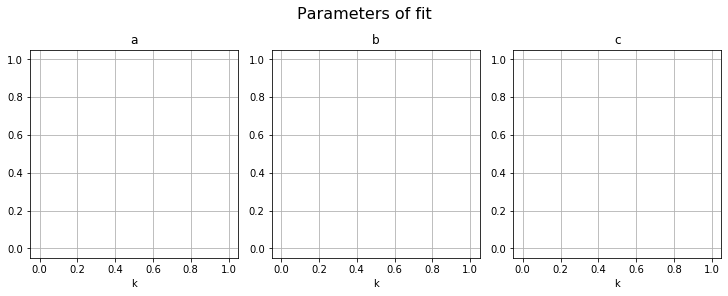

In [53]:
# plot fitting coeffiecients
fig, (ax_a, ax_b, ax_c) = plt.subplots(nrows=1, ncols=3,figsize=(10,4), constrained_layout=True)
ik1 = 1; ik2 = wavenumbers_length-1
ax_a.plot(k[ik1:ik2], optim_coef_long2_exp[ik1:ik2, 0],'.-')
ax_b.plot(k[ik1:ik2], optim_coef_long2_exp[ik1:ik2, 1],'.-')
ax_c.plot(k[ik1:ik2], optim_coef_long2_exp[ik1:ik2, 2],'.-')
ax_a.set(title='a', xlabel='k'); ax_a.grid()
ax_b.set(title='b', xlabel='k'); ax_b.grid()
ax_c.set(title='c', xlabel='k'); ax_c.grid()
fig.suptitle('Parameters of fit', fontsize=16)
plt.show()

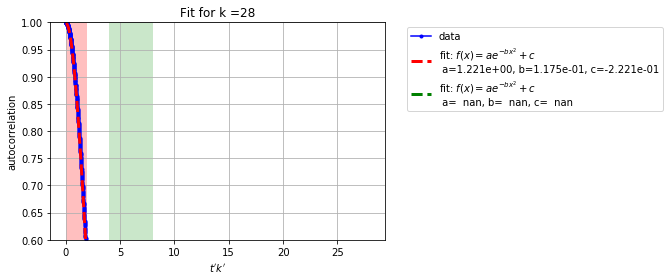

In [54]:
# Example of the exponential fit for one wavenumber
ik = 20
a = np.searchsorted(lags*k[ik]*L, 0)
b = np.searchsorted(lags*k[ik]*L, tk2_long+20)
plt.plot(lags[a:b]*k[ik]*L, autocorrelation_ampl[a:b, ik]*normalization_of_correlation_ampl[ik], 'b.-', label='data')
plt.plot(lags[a:b]*k[ik]*L, gaussian(lags[a:b]*k[ik]*L, *optim_coef_long1[ik,:]), 'r--', linewidth=3, label=r'fit: $f(x) = a e^{-b x^2} + c$' + "\n" + ' a=%5.3e, b=%5.3e, c=%5.3e' % tuple(optim_coef_long1[ik,:]))
plt.plot(lags[a:b]*k[ik]*L, exponent_function(lags[a:b]*k[ik]*L, *optim_coef_long2_exp[ik,:]), 'g--', linewidth=3, label=r'fit: $f(x) = a e^{-b x^2} + c$' + "\n" + ' a=%5.3e, b=%5.3e, c=%5.3e' % tuple(optim_coef_long2_exp[ik,:]))
#parabolic_func = np.poly1d(optim_coef_long2[ik,:])
#plt.plot(lags[a:b]*k[ik]*L, parabolic_func(lags[a:b]*k[ik]*L), 'g--', linewidth=3, label=r'fit: $f(x) = a x^2 + b x + c$' + "\n" + ' a=%5.3e, b=%5.3e, c=%5.3e' % tuple(optim_coef_long2[ik,:]))
plt.xlabel(r'$t^\prime k^\prime$'); plt.ylabel('autocorrelation'); plt.grid()
plt.axvspan(tk1_gauss, tk2_gauss, facecolor='red', alpha=0.25)
plt.axvspan(tk1_long, tk2_long, facecolor='#2ca02c', alpha=0.25)
plt.title('Fit for k =%2.f' % k[ik])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.yscale("linear")
plt.ylim([0.6,1])
plt.show()